In [2]:
import sys
sys.path.append("../../XLEMOO")

In [6]:
from XLEMOO.LEMOO import EAParams, MLParams, LEMParams, LEMOO, PastGeneration
from XLEMOO.fitness_indicators import naive_sum, must_sum_to_one, asf_wrapper, single_objective, hypervolume_contribution, inside_ranges
from XLEMOO.tree_interpreter import instantiate_tree_rules, find_all_paths
from XLEMOO.problems import river_pollution_problem
from XLEMOO.plotting import plot_best_fitnesses, plot_mean_fitnesses, plot_std_fitnesses, plot_hypervolume, show_rules
from XLEMOO.selection import SelectNBest
from desdeo_emo.recombination import SBX_xover, BP_mutation
from desdeo_emo.selection import TournamentSelection
from desdeo_problem.testproblems import test_problem_builder
from desdeo_tools.scalarization.ASF import SimpleASF, GuessASF, StomASF, PointMethodASF
from desdeo_tools.utilities import hypervolume_indicator, epsilon_indicator_ndims, fast_non_dominated_sort_indices
from typing import List

from desdeo_problem.testproblems import vehicle_crashworthiness

from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
import matplotlib.pyplot as plt
import numpy as np
from imodels import C45TreeClassifier, SlipperClassifier, BoostedRulesClassifier, SkopeRulesClassifier
import imodels

## Define problem

In [92]:
n_objectives = 3
n_variables = 5

problem = vehicle_crashworthiness()

## Setting model parameters

In [466]:
"""
nadir = np.ones(n_objectives)
ideal = np.zeros(n_objectives)
# ideal = np.array([-6.34, -3.44, -7.5, 0, 0])
# nadir = np.array([-4.75, -2.85, -0.32, 9.70, 0.35])
#ref_point = np.array([-5.0, -3.1, -4.4, 4.2, 0.15])
#guess_asf = asf_wrapper(GuessASF(nadir), {"reference_point": ref_point})

# fitness_fun = lambda x: guess_asf(x) + stom_asf(x) + np.random.uniform(0, 1)

# lower_limits = np.array([-5.5, -3.2, -5.4, 3.2, 0.05])
# upper_limits = np.array([-3.9, -2.9, -0.9, 7.2, 0.20])

lower_limits = np.array([0.4, 0.4, 0.6])
upper_limits = np.array([0.5, 0.5, 0.75])
ref_point = (lower_limits + upper_limits) / 2


stom_asf = asf_wrapper(StomASF(ideal=ideal), {"reference_point": ideal})
guess_asf = asf_wrapper(GuessASF(nadir), {"reference_point": ref_point})
ref_asf = asf_wrapper(PointMethodASF(ideal=ideal, nadir=nadir), {"reference_point": ref_point})
hyper_fun = hypervolume_contribution(nadir)
inside_ranges_fun = inside_ranges(lower_limits, upper_limits, sim_cost=0, asf_fun=ref_asf)
"""

nadir = np.array([1700, 12, 0.2])
ideal = np.array([1600, 6.0, 0.038])

ref_point = np.array([1650, 7.0, 0.05])

ref_asf = asf_wrapper(PointMethodASF(ideal=ideal, nadir=nadir), {"reference_point": ref_point})


fitness_fun = ref_asf


lem_params = LEMParams(
    use_darwin=True,
    use_ml=True,
    fitness_indicator=fitness_fun,
    ml_probe = 1,
    ml_threshold = 0.99999,
    darwin_probe = 5,
    darwin_threshold = 0.99999,
    total_iterations=300
)

ea_params = EAParams(
    population_size=200,
    cross_over_op=SBX_xover(),
    mutation_op=BP_mutation(problem.get_variable_lower_bounds(), problem.get_variable_upper_bounds()),
    # selection_op=TournamentSelection(None, tournament_size=3),
    selection_op=SelectNBest(None, 200),
    population_init_design="LHSDesign",
    iterations_per_cycle=1,
)

# ml = DecisionTreeClassifier(random_state=0)
# ml = SlipperClassifier()
# ml = BoostedRulesClassifier()
ml = SkopeRulesClassifier(precision_min=0.1, n_estimators=30, max_features=None, max_depth=None, bootstrap=True, bootstrap_features=True)
ml_params = MLParams(
    H_split=0.20,
    L_split=0.10,
    ml_model=ml,
    instantation_factor=10,
    generation_lookback=0,
    ancestral_recall=0,
    unique_only=True,
    iterations_per_cycle=1,
)

## Setup LEMOO model

In [467]:
lemoo = LEMOO(problem, lem_params, ea_params, ml_params)

In [468]:
lemoo.run_iterations()

h_gorup shape: (60, 5)
l_gorup shape: (30, 5)
.
h_gorup shape: (114, 5)
l_gorup shape: (57, 5)
.
h_gorup shape: (155, 5)
l_gorup shape: (77, 5)
.
h_gorup shape: (187, 5)
l_gorup shape: (93, 5)
.
h_gorup shape: (213, 5)
l_gorup shape: (106, 5)
.
h_gorup shape: (233, 5)
l_gorup shape: (116, 5)
.
h_gorup shape: (252, 5)
l_gorup shape: (126, 5)
.
h_gorup shape: (268, 5)
l_gorup shape: (134, 5)
.
h_gorup shape: (282, 5)
l_gorup shape: (141, 5)
.
h_gorup shape: (296, 5)
l_gorup shape: (148, 5)
.
h_gorup shape: (311, 5)
l_gorup shape: (155, 5)
.
h_gorup shape: (324, 5)
l_gorup shape: (162, 5)
.
h_gorup shape: (337, 5)
l_gorup shape: (168, 5)
.
h_gorup shape: (349, 5)
l_gorup shape: (174, 5)
.
h_gorup shape: (361, 5)
l_gorup shape: (180, 5)
.
h_gorup shape: (374, 5)
l_gorup shape: (187, 5)
.
h_gorup shape: (388, 5)
l_gorup shape: (194, 5)
.
h_gorup shape: (401, 5)
l_gorup shape: (200, 5)
.
h_gorup shape: (413, 5)
l_gorup shape: (206, 5)
.
h_gorup shape: (425, 5)
l_gorup shape: (212, 5)
.
h_gor

{'darwin_mode': 300, 'learning_mode': 300, 'total_iterations': 300}

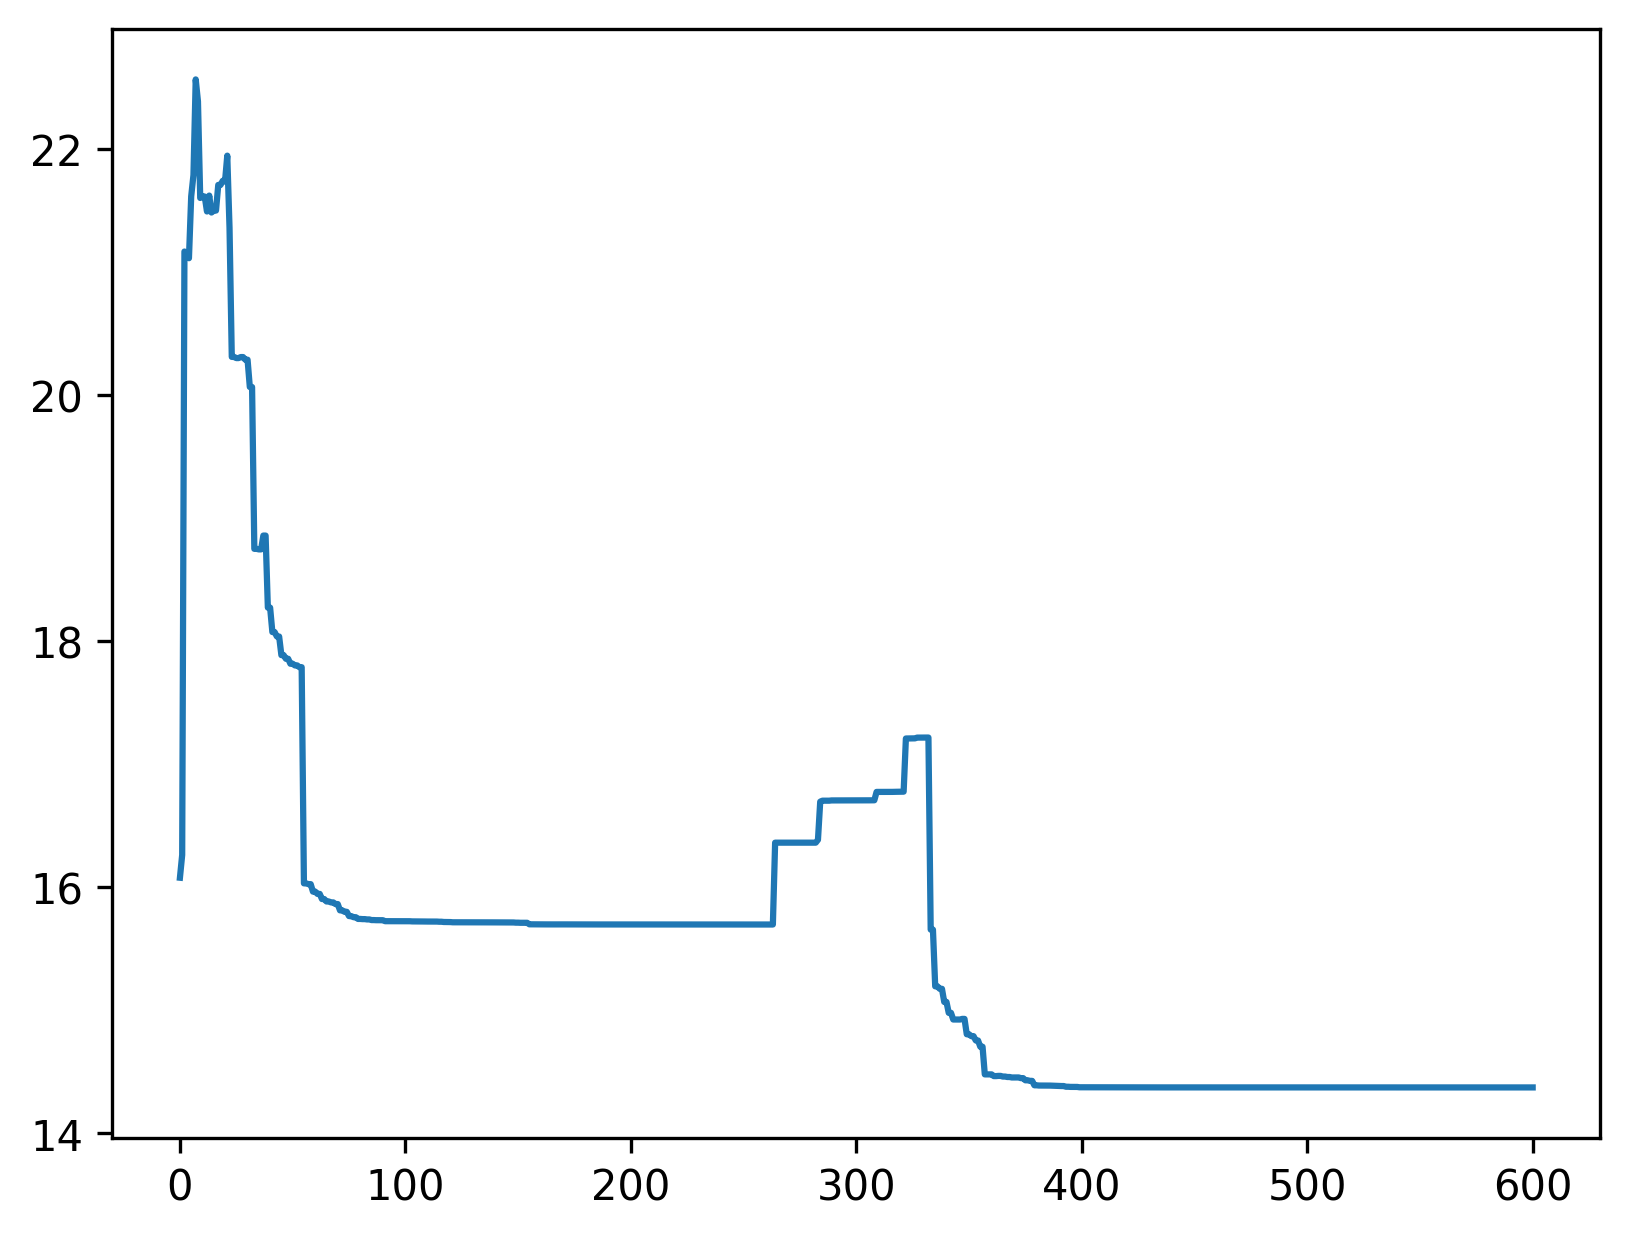

In [469]:
plot_hypervolume(lemoo._generation_history, ref_point=nadir)

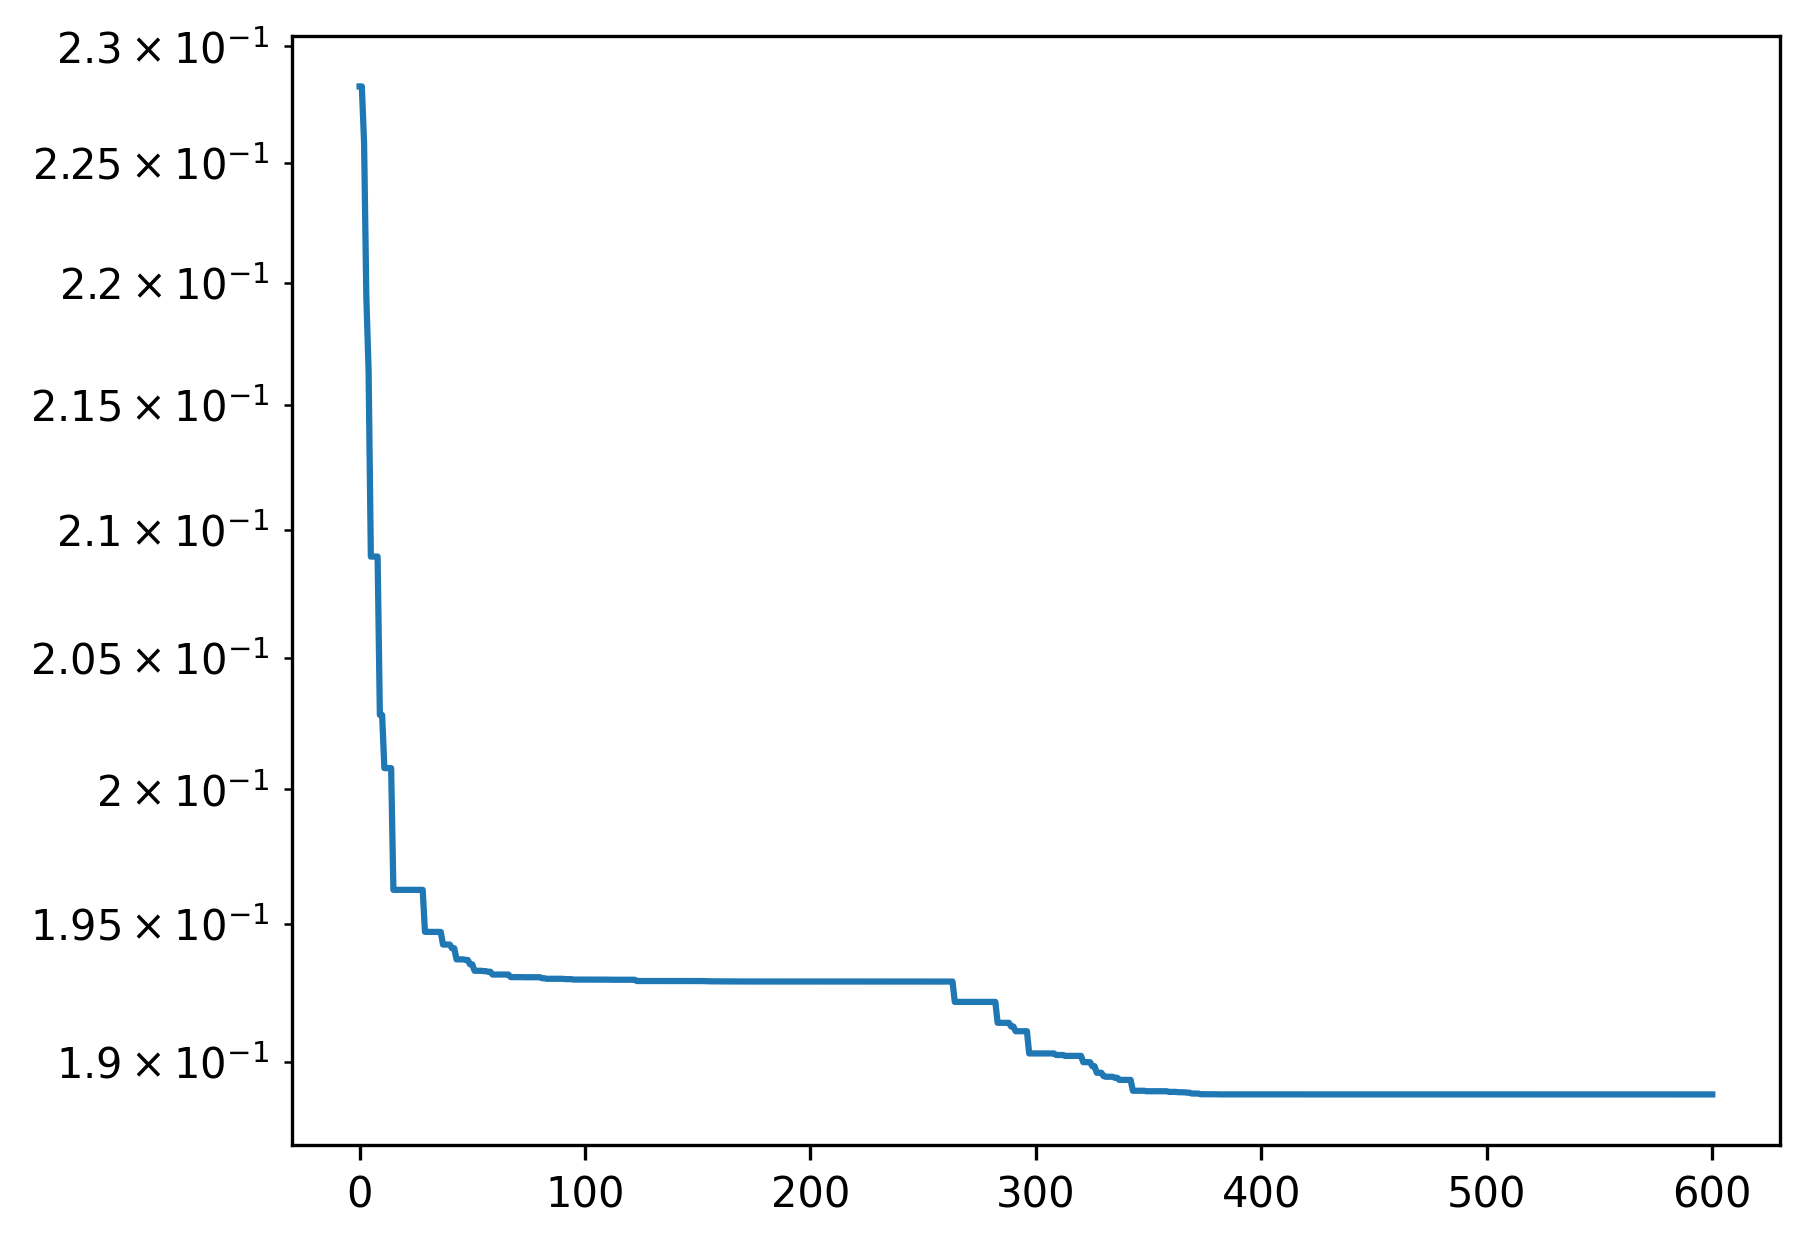

In [470]:
plot_best_fitnesses(lemoo._generation_history, ylog=True)

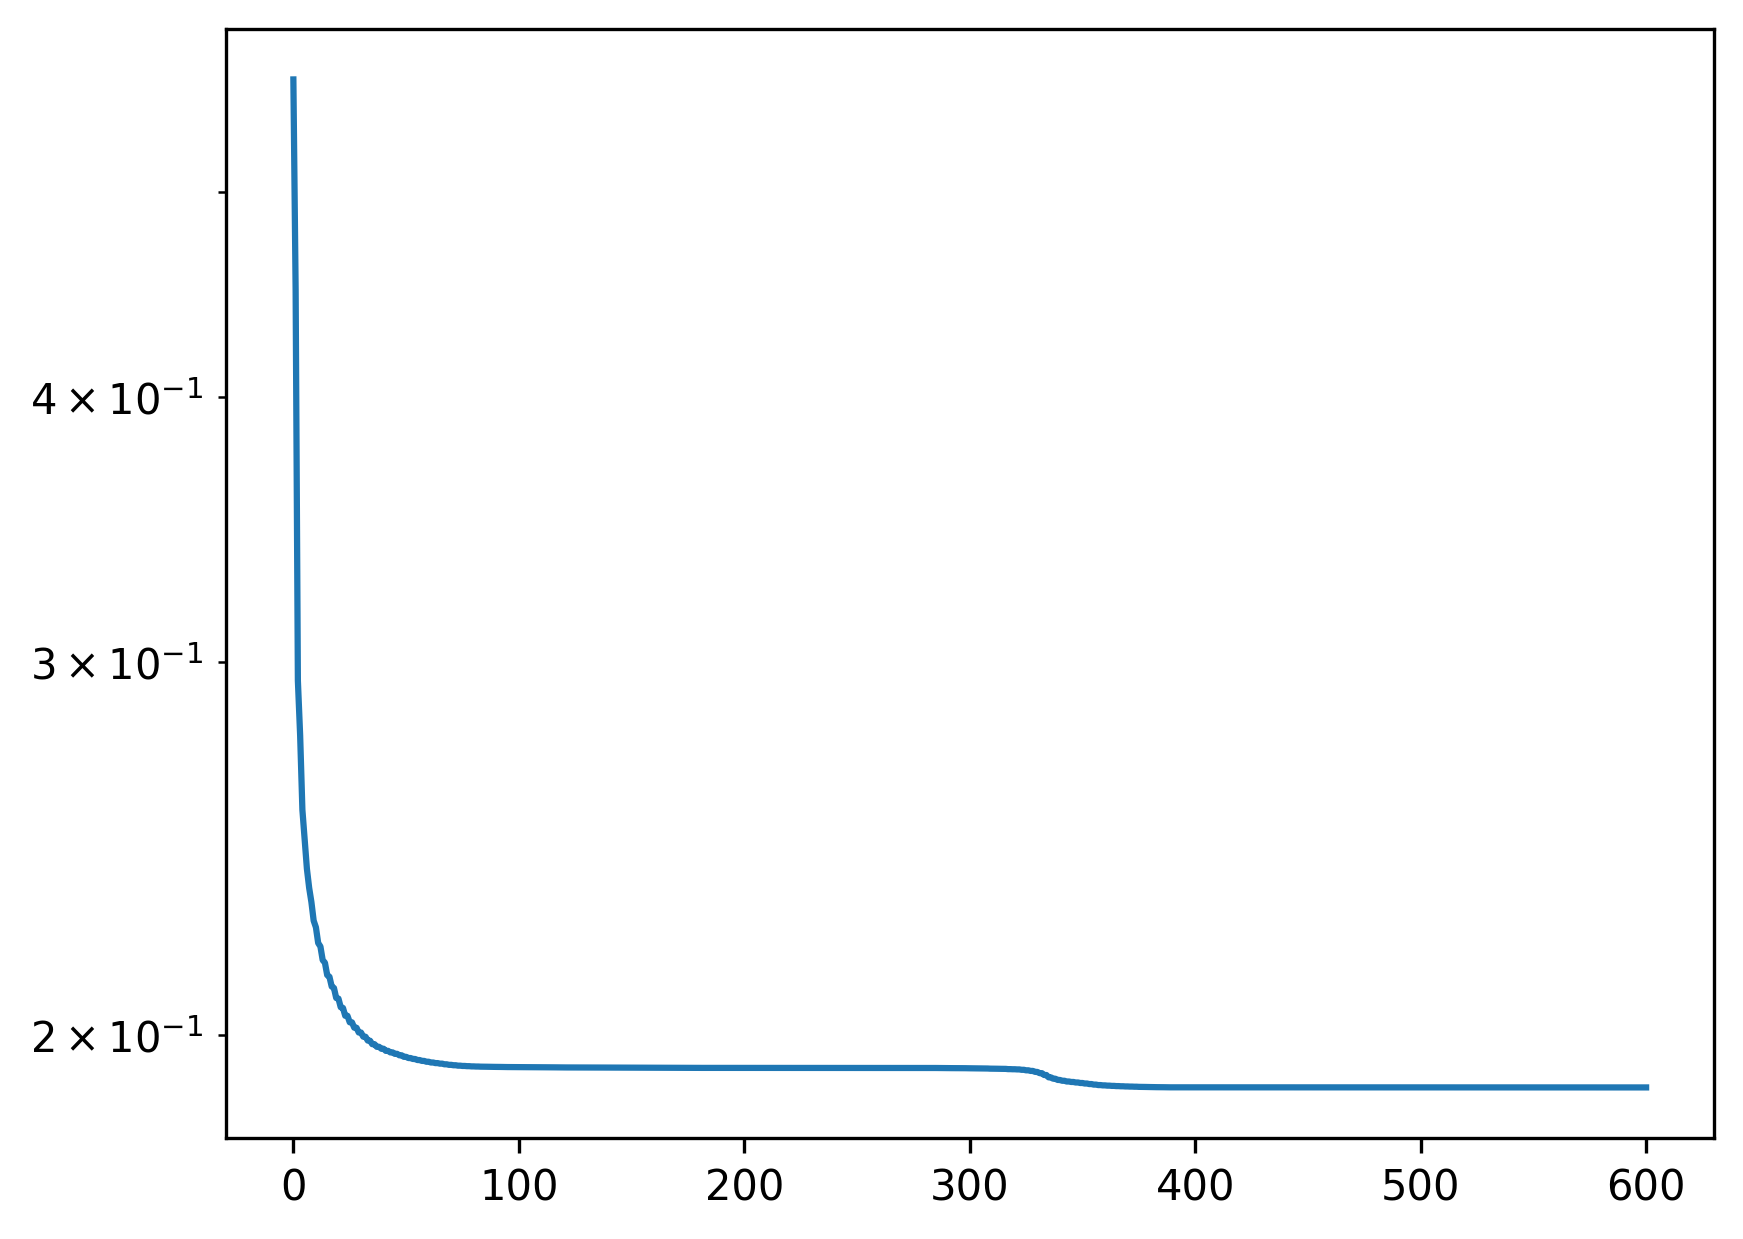

In [471]:
plot_mean_fitnesses(lemoo._generation_history, ylog=True)

SkopeRulesClassifier(bootstrap=True, bootstrap_features=True, max_depth=None,
                     max_features=None, n_estimators=30, precision_min=0.1)


AttributeError: 'SkopeRulesClassifier' object has no attribute 'tree_'

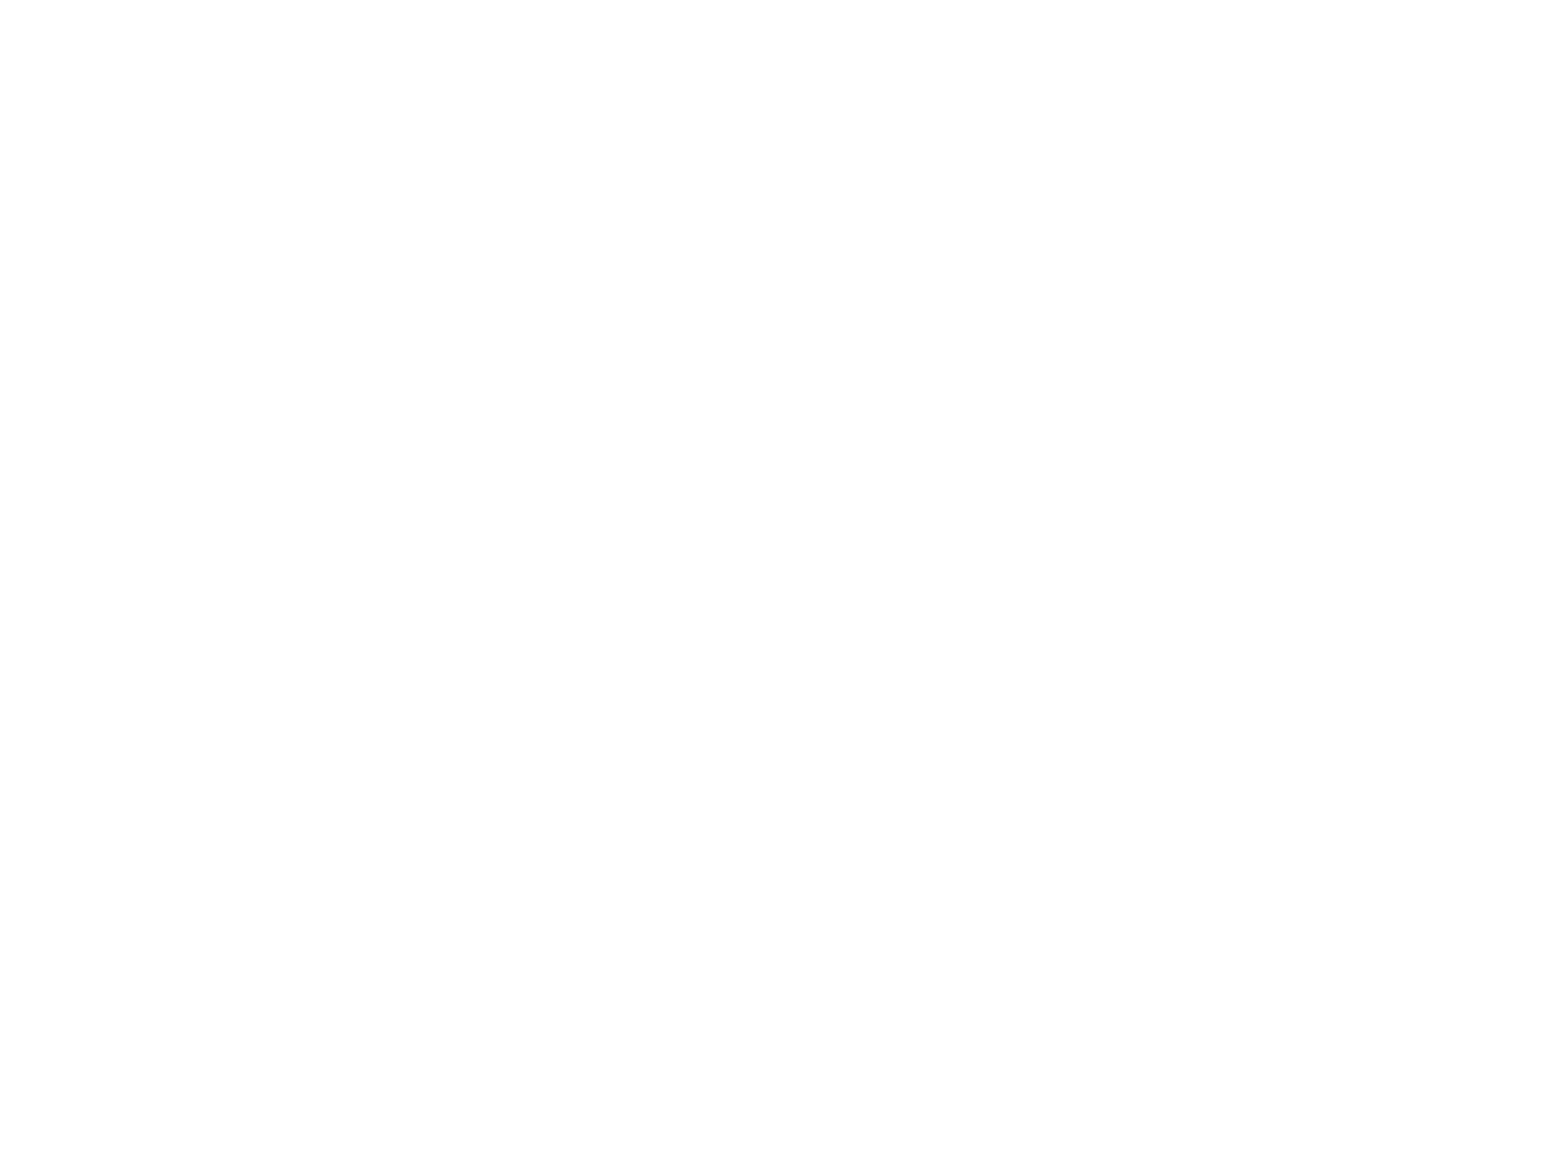

In [472]:
print(lemoo.current_ml_model)
tree.plot_tree(lemoo.current_ml_model)

In [473]:
print(problem.evaluate(lemoo._generation_history[-1].individuals[0]).objectives)
print(lower_limits)
print(upper_limits)

[[1.66887397e+03 8.13299521e+00 8.05910457e-02]]


NameError: name 'lower_limits' is not defined

In [474]:
np.min(lemoo._generation_history[-1].fitness_fun_values)


0.18885104495212424

In [475]:
# print(lemoo.current_ml_model.rules_[1])
show_rules(lemoo.current_ml_model.rules_)

Rule -> Accuracy:
X_2 <= 1.00299 and X_3 <= 1.00011 --> 1.0
X_0 <= 1.00007 and X_2 <= 1.00004 --> 1.0
X_3 <= 1.00011 and X_4 > 2.30631 --> 1.0
X_0 <= 1.0089 and X_3 <= 1.00009 --> 1.0
X_2 <= 1.00299 and X_3 <= 1.00009 --> 1.0
X_1 <= 1.6885 and X_1 > 1.30854 and X_3 <= 1.00013 --> 1.0
X_0 <= 1.00012 and X_2 <= 1.00004 --> 1.0
X_0 <= 1.0089 and X_3 <= 1.00011 --> 1.0
X_1 <= 1.6885 and X_1 > 1.35156 and X_3 <= 1.00013 --> 1.0
X_1 > 1.35156 and X_3 <= 1.00011 --> 0.9994044073853484
X_2 <= 1.02044 and X_3 <= 1.00011 --> 0.9993968417499011
X_3 <= 1.00011 and X_4 > 1.88989 --> 0.9993954050785974
X_3 <= 1.00009 and X_4 > 1.77945 --> 0.9993913572732805
X_2 <= 1.02065 and X_3 <= 1.00013 --> 0.9993885042537454
X_2 <= 1.02044 and X_3 <= 1.00009 --> 0.9993865030674847
X_3 <= 1.00013 and X_4 > 1.77949 --> 0.9993765586034913
X_3 <= 1.00025 and X_4 > 2.30631 --> 0.9988009592326139
X_3 <= 1.00025 and X_4 > 1.88989 --> 0.998176291793313
X_3 <= 1.00009 --> 0.9975139828806279
X_2 > 1.0 --> 0.6589872665358

In [476]:
#print(np.logical_and(lemoo._generation_history[-1].objectives_fitnesses <= upper_limits, lemoo._generation_history[-1].objectives_fitnesses >= lower_limits))
a = lemoo._generation_history[-1].objectives_fitnesses[0:3]

fitness_fun(np.atleast_2d(a))

array([[0.18885104],
       [0.18885104],
       [0.18885104]])

In [478]:
lemoo._generation_history[-2].individuals

array([[1.        , 1.42782382, 1.        , 1.        , 2.38528018],
       [1.        , 1.42782382, 1.        , 1.        , 2.38528018],
       [1.        , 1.42782382, 1.        , 1.        , 2.38528018],
       [1.        , 1.42782382, 1.        , 1.        , 2.38528018],
       [1.        , 1.42782382, 1.        , 1.        , 2.38528018],
       [1.        , 1.42782382, 1.        , 1.        , 2.38528018],
       [1.        , 1.42782382, 1.        , 1.        , 2.38528018],
       [1.        , 1.42782382, 1.        , 1.        , 2.38528018],
       [1.        , 1.42782382, 1.        , 1.        , 2.38528018],
       [1.        , 1.42782382, 1.        , 1.        , 2.38528018],
       [1.        , 1.42782382, 1.        , 1.        , 2.38528018],
       [1.        , 1.42782382, 1.        , 1.        , 2.38528018],
       [1.        , 1.42782382, 1.        , 1.        , 2.38528018],
       [1.        , 1.42782382, 1.        , 1.        , 2.38528018],
       [1.        , 1.42782382, 1.

In [153]:
upper_limits

NameError: name 'upper_limits' is not defined

In [154]:
a - lower_limits

NameError: name 'lower_limits' is not defined

In [ ]:
upper_limits - a

In [ ]:
lower = np.where(a - lower_limits > 0, 0, np.abs(a - lower_limits))
upper = np.where(upper_limits - a > 0, 0, np.abs(upper_limits - a))

In [ ]:
lower

In [ ]:
upper

In [ ]:
lower + upper

In [ ]:
np.sum(lower + upper, axis=1).T

In [ ]:
fitness_fun(a)